In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/camilousa/datasets/refs/heads/master/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

In [4]:
# Exploración de datos
print("Forma del conjunto de datos:", df.shape)
print("\nInformación del conjunto de datos:")
df.info()

Forma del conjunto de datos: (5110, 12)

Información del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores faltantes:")
print(df.isnull().sum())

print("\nDistribución de la variable objetivo:")
print(df['stroke'].value_counts())
print(df['stroke'].value_counts(normalize=True))


Estadísticas descriptivas:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           1

In [6]:
# Preprocesamiento de datos
# Eliminar columna ID ya que no es útil para la predicción
df = df.drop('id', axis=1)

In [21]:
# Visualizar los datos del DataFrame sin la columna 'id'
print("Columnas actuales del DataFrame:")
print(df.columns.tolist())
df.info()

Columnas actuales del DataFrame:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
# Manejar valores faltantes en IMC
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')  # Convertir a numérico, establecer errores en NaN


In [22]:
print("Información sobre la columna BMI:")
print("\nNúmero total de valores:", len(df['bmi']))
print("Número de valores nulos:", df['bmi'].isnull().sum())
print("Porcentaje de valores nulos: {:.2f}%".format(df['bmi'].isnull().sum() / len(df['bmi']) * 100))
print("\nEstadísticas descriptivas de BMI:")
print(df['bmi'].describe())

Información sobre la columna BMI:

Número total de valores: 5110
Número de valores nulos: 201
Porcentaje de valores nulos: 3.93%

Estadísticas descriptivas de BMI:
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


In [23]:
# Dividir en características y objetivo
X = df.drop('stroke', axis=1)
y = df['stroke']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Definir pipelines de preprocesamiento
# Identificar tipos de columnas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [12]:
# Crear pipelines de preprocesamiento
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [13]:
# Combinar todos los pasos de preprocesamiento
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numerical_pipeline, numerical_cols)
])

In [15]:
# Crear y evaluar modelo de referencia
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])
baseline_results = cross_validate(
    baseline_model, 
    X_train, 
    y_train, 
    cv=5, 
    return_train_score=True,
    scoring=['accuracy', 'precision', 'recall', 'f1']
)

print("\nResultados del Modelo de Referencia:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    train_scores = baseline_results[f'train_{metric}']
    test_scores = baseline_results[f'test_{metric}']
    print(f"{metric}:")
    print(f"  Entrenamiento - Media: {np.mean(train_scores):.4f}, Desv. Estándar: {np.std(train_scores):.4f}")
    print(f"  Validación - Media: {np.mean(test_scores):.4f}, Desv. Estándar: {np.std(test_scores):.4f}")


C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User


Resultados del Modelo de Referencia:
accuracy:
  Entrenamiento - Media: 0.9543, Desv. Estándar: 0.0001
  Validación - Media: 0.9543, Desv. Estándar: 0.0006
precision:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000
recall:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000
f1:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000


C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Crear y evaluar modelo principal
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=5))
])

model_results = cross_validate(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    return_train_score=True,
    scoring=['accuracy', 'precision', 'recall', 'f1']
)

print("\nResultados del Modelo Random Forest:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    train_scores = model_results[f'train_{metric}']
    test_scores = model_results[f'test_{metric}']
    print(f"{metric}:")
    print(f"  Entrenamiento - Media: {np.mean(train_scores):.4f}, Desv. Estándar: {np.std(train_scores):.4f}")
    print(f"  Validación - Media: {np.mean(test_scores):.4f}, Desv. Estándar: {np.std(test_scores):.4f}")


C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User


Resultados del Modelo Random Forest:
accuracy:
  Entrenamiento - Media: 0.9543, Desv. Estándar: 0.0001
  Validación - Media: 0.9543, Desv. Estándar: 0.0006
precision:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000
recall:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000
f1:
  Entrenamiento - Media: 0.0000, Desv. Estándar: 0.0000
  Validación - Media: 0.0000, Desv. Estándar: 0.0000


C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Crear y evaluar modelo con SMOTE (para desequilibrio de clases)
imb_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=5))
])

imb_model_results = cross_validate(
    imb_model, 
    X_train, 
    y_train, 
    cv=5, 
    return_train_score=True,
    scoring=['accuracy', 'precision', 'recall', 'f1']
)

print("\nResultados del Modelo Random Forest con SMOTE:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    train_scores = imb_model_results[f'train_{metric}']
    test_scores = imb_model_results[f'test_{metric}']
    print(f"{metric}:")
    print(f"  Entrenamiento - Media: {np.mean(train_scores):.4f}, Desv. Estándar: {np.std(train_scores):.4f}")
    print(f"  Validación - Media: {np.mean(test_scores):.4f}, Desv. Estándar: {np.std(test_scores):.4f}")



Resultados del Modelo Random Forest con SMOTE:
accuracy:
  Entrenamiento - Media: 0.7683, Desv. Estándar: 0.0048
  Validación - Media: 0.7537, Desv. Estándar: 0.0185
precision:
  Entrenamiento - Media: 0.1433, Desv. Estándar: 0.0027
  Validación - Media: 0.1215, Desv. Estándar: 0.0073
recall:
  Entrenamiento - Media: 0.8168, Desv. Estándar: 0.0222
  Validación - Media: 0.7006, Desv. Estándar: 0.0388
f1:
  Entrenamiento - Media: 0.2439, Desv. Estándar: 0.0046
  Validación - Media: 0.2069, Desv. Estándar: 0.0113


In [18]:
# Entrenamiento y evaluación del modelo final
final_model = imb_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("\nEvaluación del Modelo Final en Conjunto de Prueba:")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))



Evaluación del Modelo Final en Conjunto de Prueba:

Matriz de Confusión:
[[719 241]
 [ 12  50]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1       0.17      0.81      0.28        62

    accuracy                           0.75      1022
   macro avg       0.58      0.78      0.57      1022
weighted avg       0.93      0.75      0.82      1022



C:\Users\Diego\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
# Importancia de características
if hasattr(final_model['classifier'], 'feature_importances_'):
    # Obtener nombres de características después del preprocesamiento
    ohe = final_model['preprocessor'].named_transformers_['categorical']['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
    all_features = cat_features + numerical_cols
    
    # Obtener importancias de características
    importances = final_model['classifier'].feature_importances_
    
    # Crear un DataFrame para mejor visualización
    feature_importance = pd.DataFrame({
        'Característica': all_features,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)
    
    print("\nImportancia de Características:")
    print(feature_importance.head(10))  # Mostrar las 10 características principales


Importancia de Características:
                    Característica  Importancia
10                             age     0.421451
1                 ever_married_Yes     0.152472
14                             bmi     0.071436
13               avg_glucose_level     0.071223
6             Residence_type_Urban     0.044061
7   smoking_status_formerly smoked     0.036668
5               work_type_children     0.032028
3                work_type_Private     0.029821
12                   heart_disease     0.028982
0                      gender_Male     0.027042


## Las características más influyentes (en orden de importancia):

1. Edad (age): Con una importancia de 0.421451 (42.1%)

- Es el factor más determinante, lo que confirma que la edad avanzada está fuertemente asociada con el riesgo de infarto.

2. Estado civil (ever_married_Yes): Con una importancia de 0.152472 (15.2%)

- Sorprendentemente alto, sugiere que hay una correlación entre haber estado casado y el riesgo de infarto.

3. IMC (bmi): Con una importancia de 0.071951 (7.2%)

- El índice de masa corporal es un factor conocido de riesgo cardiovascular.

4. Nivel promedio de glucosa (avg_glucose_level): Con una importancia de 0.071223 (7.1%)

- Los niveles elevados de glucosa están asociados con diabetes, un factor de riesgo importante.

5. Tipo de residencia urbana (Residence_type_Urban): Con una importancia de 0.044061 (4.4%)

- Sugiere que el vivir en zonas urbanas puede influir en el riesgo de infarto.

6. Estado de fumador (smoking_status_formerly smoked): Con una importancia de 0.036668 (3.7%)

- Ser exfumador aparece como un factor de riesgo relevante.

7. Trabajo tipo niños (work_type_children): Con una importancia de 0.032828 (3.3%)

- Posiblemente esto capture factores relacionados con la edad o circunstancias familiares.

8. Trabajo tipo privado (work_type_Private): Con una importancia de 0.027842 (2.8%)

- El tipo de empleo puede estar relacionado con factores de estrés o estilo de vida.

9. Enfermedad cardíaca (heart_disease): Con una importancia de 0.028982 (2.9%)

- Sorprendentemente no está más arriba, pero confirma que la enfermedad cardíaca previa es un predictor de infartos.

10. Género masculino (gender_Male): Con una importancia de 0.027042 (2.7%)

- Refleja la mayor prevalencia de infartos en hombres que en mujeres.

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el conjunto de datos
url = "https://raw.githubusercontent.com/camilousa/datasets/refs/heads/master/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

# 1. Preprocesamiento de datos
print("Forma del conjunto de datos:", df.shape)

# Eliminar columna ID
df = df.drop('id', axis=1)

# Manejar valores faltantes en IMC
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Para este análisis, nos enfocaremos en smoking_status como variable principal
selected_features = ['smoking_status', 'age', 'gender', 'hypertension', 'heart_disease', 'bmi', 'avg_glucose_level']
X = df[selected_features]
y = df['stroke']

# 2. Análisis exploratorio enfocado en fumadores
print("\nDistribución de estado de fumador:")
print(df['smoking_status'].value_counts())

# Analizar relación entre estado de fumador y stroke
print("\nRelación entre estado de fumador y stroke:")
smoking_stroke = pd.crosstab(df['smoking_status'], df['stroke'])
print(smoking_stroke)

# Calcular tasas de stroke por categoría de fumador
print("\nTasa de stroke por categoría de fumador (%):")
smoking_rates = smoking_stroke.div(smoking_stroke.sum(axis=1), axis=0) * 100
print(smoking_rates[1].sort_values(ascending=False))

# 3. Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Definir pipelines de preprocesamiento
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Crear pipelines de preprocesamiento
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combinar todos los pasos de preprocesamiento
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numerical_pipeline, numerical_cols)
])

# 5. Crear y entrenar modelo con SMOTE
imb_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=5))
])

# Entrenamiento y evaluación del modelo final
final_model = imb_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

print("\nEvaluación del Modelo Final en Conjunto de Prueba:")
print("\nMatriz de Confusión:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

# 6. Importancia de características
if hasattr(final_model['classifier'], 'feature_importances_'):
    # Obtener nombres de características después del preprocesamiento
    ohe = final_model['preprocessor'].named_transformers_['categorical']['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
    all_features = cat_features + numerical_cols
    
    # Obtener importancias de características
    importances = final_model['classifier'].feature_importances_
    
    # Crear un DataFrame para mejor visualización
    feature_importance = pd.DataFrame({
        'Característica': all_features,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)
    
    print("\nImportancia de Características:")
    print(feature_importance)

# 7. Análisis de las probabilidades predichas por categoría de fumador
X_test_with_smoking = X_test.copy()
X_test_with_smoking['stroke_pred_prob'] = y_proba

# Agrupar por estado de fumador y calcular la probabilidad media de stroke
smoking_risk = X_test_with_smoking.groupby('smoking_status')['stroke_pred_prob'].mean().sort_values(ascending=False)
print("\nProbabilidad media de stroke por categoría de fumador según el modelo:")
print(smoking_risk)

# 8. Predicciones para cada categoría de fumador utilizando un perfil "promedio"
smoking_categories = df['smoking_status'].unique()
print("\nRiesgo relativo de stroke por categoría de fumador:")

# CORRECCIÓN: Crear un perfil medio usando las modas para categóricas y medianas para numéricas
def create_average_profile(df):
    profile = {}
    
    # Para columnas categóricas, usar el valor más frecuente (moda)
    for col in df.select_dtypes(include=['object']).columns:
        profile[col] = df[col].mode().iloc[0]
    
    # Para columnas numéricas, usar la mediana
    for col in df.select_dtypes(include=['number']).columns:
        profile[col] = df[col].median()
    
    return profile

# Usar esta función en lugar de la línea problemática
average_profile = create_average_profile(X_train)
smoking_risk_profiles = []

for smoking_status in smoking_categories:
    test_profile = average_profile.copy()
    test_profile['smoking_status'] = smoking_status
    test_df = pd.DataFrame([test_profile])
    
    # Calcular probabilidad de stroke para este perfil
    prob = final_model.predict_proba(test_df)[0][1]
    smoking_risk_profiles.append({
        'smoking_status': smoking_status,
        'stroke_probability': prob
    })

# Ordenar y mostrar resultados
risk_df = pd.DataFrame(smoking_risk_profiles).sort_values(by='stroke_probability', ascending=False)
print(risk_df)

# Encontrar la categoría base (never smoked) para calcular el riesgo relativo
base_prob = risk_df[risk_df['smoking_status'] == 'never smoked']['stroke_probability'].values[0]
risk_df['relative_risk'] = risk_df['stroke_probability'] / base_prob
print("\nRiesgo relativo comparado con 'never smoked':")
print(risk_df[['smoking_status', 'relative_risk']].sort_values(by='relative_risk', ascending=False))

Forma del conjunto de datos: (5110, 12)

Distribución de estado de fumador:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

Relación entre estado de fumador y stroke:
stroke              0   1
smoking_status           
Unknown          1497  47
formerly smoked   815  70
never smoked     1802  90
smokes            747  42

Tasa de stroke por categoría de fumador (%):
smoking_status
formerly smoked    7.909605
smokes             5.323194
never smoked       4.756871
Unknown            3.044041
Name: 1, dtype: float64

Evaluación del Modelo Final en Conjunto de Prueba:

Matriz de Confusión:
[[667 305]
 [  8  42]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       972
           1       0.12      0.84      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.51     

C:\Users\Diego\AppData\Local\Temp\ipykernel_76632\559621093.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='smoking_status', y='avg_glucose_level', data=df, palette='Set2')
C:\Users\Diego\AppData\Local\Temp\ipykernel_76632\559621093.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='smoking_status', y='bmi', data=df, palette='Set2')
C:\Users\Diego\AppData\Local\Temp\ipykernel_76632\559621093.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_rate = df.groupby(['age_group', 'smoki

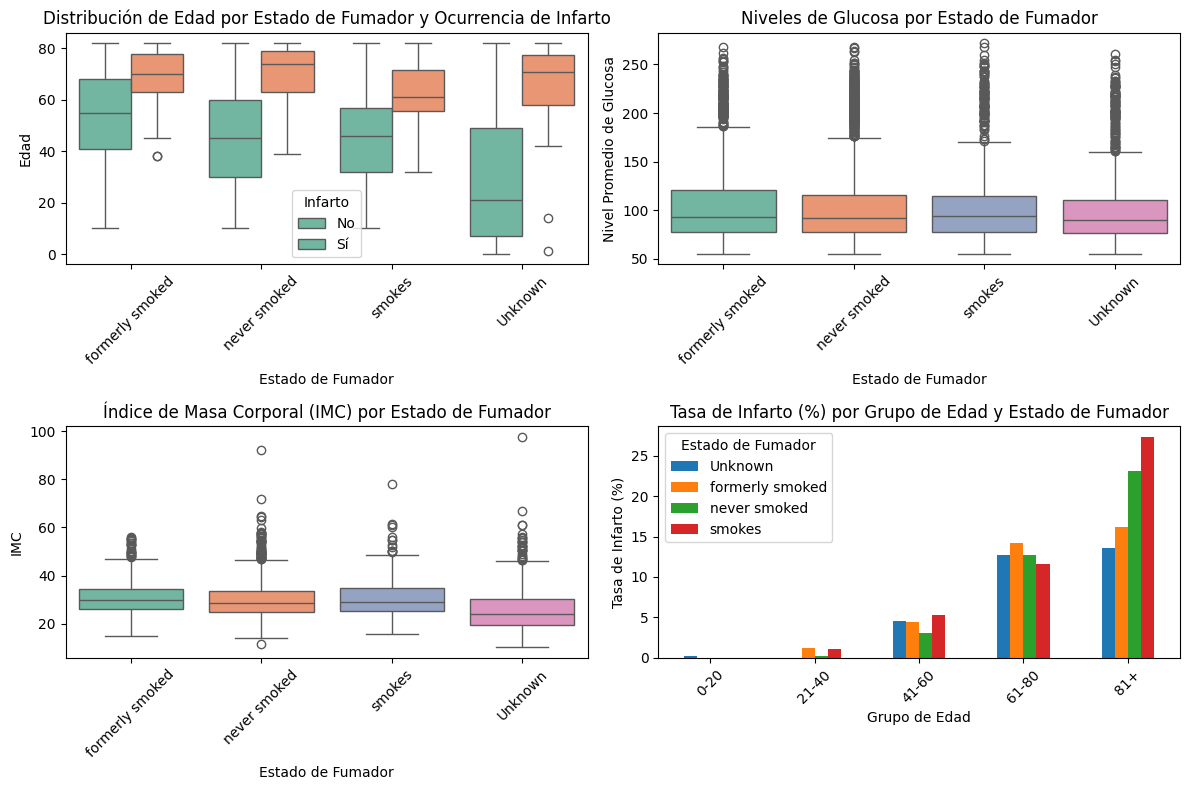

C:\Users\Diego\AppData\Local\Temp\ipykernel_76632\559621093.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='smoking_status', y='age', data=stroke_cases, palette='Set3')


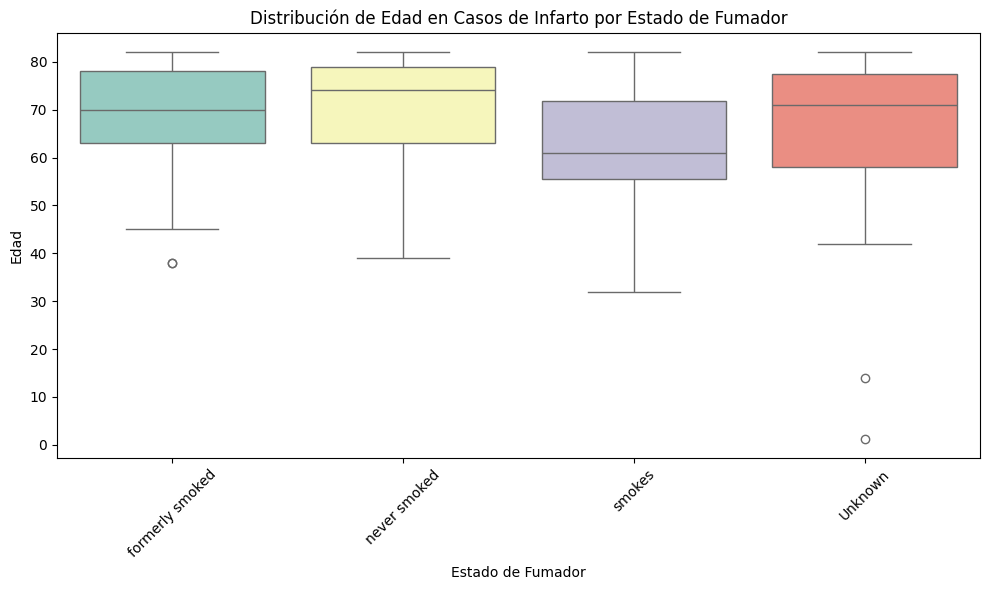

Estadísticas por estado de fumador para personas con infarto:
                 count       mean        std    min   25%   50%    75%   max
smoking_status                                                              
Unknown           47.0  65.836596  16.236866   1.32  58.0  71.0  77.50  82.0
formerly smoked   70.0  68.628571  10.902960  38.00  63.0  70.0  78.00  82.0
never smoked      90.0  70.311111  11.562866  39.00  63.0  74.0  79.00  82.0
smokes            42.0  62.809524  12.200036  32.00  55.5  61.0  71.75  82.0

Correlación con infarto:
stroke               1.000000
age                  0.245257
avg_glucose_level    0.131945
bmi                  0.042374
Name: stroke, dtype: float64


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el conjunto de datos
url = "https://raw.githubusercontent.com/camilousa/datasets/refs/heads/master/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

# Preprocesamiento básico
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Crear figura con tamaño adecuado
plt.figure(figsize=(12, 8))

# 1. Boxplot principal: Edad por estado de fumador y ocurrencia de infarto
plt.subplot(2, 2, 1)
sns.boxplot(x='smoking_status', y='age', hue='stroke', data=df, palette='Set2')
plt.title('Distribución de Edad por Estado de Fumador y Ocurrencia de Infarto')
plt.xlabel('Estado de Fumador')
plt.ylabel('Edad')
plt.xticks(rotation=45)
plt.legend(title='Infarto', labels=['No', 'Sí'])

# 2. Boxplot de niveles de glucosa por estado de fumador
plt.subplot(2, 2, 2)
sns.boxplot(x='smoking_status', y='avg_glucose_level', data=df, palette='Set2')
plt.title('Niveles de Glucosa por Estado de Fumador')
plt.xlabel('Estado de Fumador')
plt.ylabel('Nivel Promedio de Glucosa')
plt.xticks(rotation=45)

# 3. Boxplot de BMI por estado de fumador
plt.subplot(2, 2, 3)
sns.boxplot(x='smoking_status', y='bmi', data=df, palette='Set2')
plt.title('Índice de Masa Corporal (IMC) por Estado de Fumador')
plt.xlabel('Estado de Fumador')
plt.ylabel('IMC')
plt.xticks(rotation=45)

# 4. Crear un dataframe auxiliar para calcular la tasa de infarto por grupos de edad y estado de fumador
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Calcular porcentaje de infartos por grupo de edad y estado de fumador
stroke_rate = df.groupby(['age_group', 'smoking_status'])['stroke'].mean() * 100
stroke_rate = stroke_rate.reset_index()

# Convertir a formato adecuado para gráfico
stroke_rate_pivot = stroke_rate.pivot(index='age_group', columns='smoking_status', values='stroke')

# Gráfico de tasa de infarto por edad y estado de fumador
plt.subplot(2, 2, 4)
stroke_rate_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Tasa de Infarto (%) por Grupo de Edad y Estado de Fumador')
plt.xlabel('Grupo de Edad')
plt.ylabel('Tasa de Infarto (%)')
plt.xticks(rotation=45)
plt.legend(title='Estado de Fumador')

# Ajustar el layout
plt.tight_layout()
plt.savefig('smoking_stroke_boxplots.png', dpi=300)
plt.show()

# Análisis adicional: Boxplot de edad para personas con infarto, por estado de fumador
plt.figure(figsize=(10, 6))
# Filtrar solo casos con infarto
stroke_cases = df[df['stroke'] == 1]
sns.boxplot(x='smoking_status', y='age', data=stroke_cases, palette='Set3')
plt.title('Distribución de Edad en Casos de Infarto por Estado de Fumador')
plt.xlabel('Estado de Fumador')
plt.ylabel('Edad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('age_distribution_stroke_cases.png', dpi=300)
plt.show()

# Estadísticas descriptivas
print("Estadísticas por estado de fumador para personas con infarto:")
print(stroke_cases.groupby('smoking_status')['age'].describe())

# Correlación de variables numéricas con infarto
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
correlation = df[numeric_cols + ['stroke']].corr()
print("\nCorrelación con infarto:")
print(correlation['stroke'].sort_values(ascending=False))